In [1]:
#import some stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import glob
import time
from sklearn.model_selection import train_test_split #use this?
from scipy import stats
import xgboost as xgb

In [2]:
csvPath = r'D:\\Thesis2021\nba-movement-data\data\dataAndLabel'
#df = pd.read_csv('nba-movement-data\data\dataAndLabel\0021500001_dataAndLabel.csv')
df = pd.read_csv(csvPath + '/0021500001_dataAndLabel.csv')

games = os.listdir(csvPath)
all_files = glob.glob(os.path.join(csvPath, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files[30:31]) #can make this as much or little as you want
print(all_files[30:31])
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

C:\Users\JCHam\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (82,84) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['D:\\\\Thesis2021\\nba-movement-data\\data\\dataAndLabel\\0021500035_dataAndLabel.csv']


C:\Users\JCHam\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DtypeWarning: Columns (82,84) have mixed types.Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


In [3]:
#if we want all columns
pd.set_option('display.max_columns', 28)
df.head()

,game_clock,shot_clock,quarter,game_id,event_id,team_id1,player_id1,x_loc1,y_loc1,speed1,angle1,radius1,team_id2,player_id2,...,angle11,radius11,isTO,isFT,isReb,isFTMade,FTsMade,NonShotPlayerID,NonShotPlayerName,ShotPlayerID,ShotPlayerName,SHOT_TIME,possPoints,isShot
0,720.00,24.00,1,21500001,1,-1,-1,11.4806,419.9969,0.000000,0.000000,6.76567,1610612737,2594,...,0.000000,0.0,False,0.0,False,0.0,0.0,201143.0,Al Horford,NaN,NaN,NaN,0.0,False
1,719.98,23.90,1,21500001,1,-1,-1,26.8673,357.7526,0.000000,0.000000,6.47278,1610612737,2594,...,0.000000,0.0,False,0.0,False,0.0,0.0,201143.0,Al Horford,NaN,NaN,NaN,0.0,False
2,719.94,23.86,1,21500001,1,-1,-1,25.1361,357.9653,43.605438,-0.122250,6.09299,1610612737,2594,...,2.205247,0.0,False,0.0,False,0.0,0.0,201143.0,Al Horford,NaN,NaN,NaN,0.0,False
3,719.90,23.82,1,21500001,1,-1,-1,25.0770,355.3443,65.541656,1.548252,6.16468,1610612737,2594,...,2.449521,0.0,False,0.0,False,0.0,0.0,201143.0,Al Horford,NaN,NaN,NaN,0.0,False
4,719.86,23.78,1,21500001,1,-1,-1,24.0813,353.8495,44.901597,0.983180,6.11854,1610612737,2594,...,1.988319,0.0,False,0.0,False,0.0,0.0,201143.0,Al Horford,NaN,NaN,NaN,0.0,False


In [4]:
#this will load the EP model

epModel = xgb.Booster({'nthread':4})
epModel.load_model('xgbModel.json')

In [5]:
def getDist(x1,x2,y1,y2):
    return ((x2-x1)**2 + (y2-y1)**2)**0.5

#this assumes ball is player_id1 in all rows
def isClosestToBall(row):
    closest = -1
    closestTeam = -2
    closestDist = 100000
    ballx = row['x_loc1']
    bally = row['y_loc1']
    for i in range(2,12):
        tempDist = getDist(ballx,row['x_loc' + str(i)],bally,row['y_loc' + str(i)]) 
        if tempDist < closestDist:
            closest = i
            closestDist = tempDist
            closestTeam = i
    closestTeam = row['team_id' + str(closestTeam)]
    return [closest,round(closestDist,3),closestTeam]

#assumes ball is player_id1
#forPlayer is bool on - True if for player row, False for team row
def hasBall(row,forPlayer):
    #45.2 is about 4 feet (i.e. half the largest wingspan in league)
    #ball is less than 9 feet in air to be possessed
    playerClosest,distToBall,teamClosest = row['ClosestToBall']
    if (distToBall < 45.2) and (row['radius1'] < 9):
        if forPlayer:
            return row['player_id' + str(playerClosest)]
        else:
            return teamClosest
    else:
        return -2 #no player has ball

In [6]:
def getDFReady(df):
    df = df.copy()
    df['possPoints'] = df.apply(lambda row: 0 if pd.isnull(row['possPoints']) else row['possPoints'],axis=1)
    df = df[['shot_clock','x_loc1','y_loc1','speed1','angle1','radius1','x_loc2','y_loc2','speed2','angle2','x_loc3','y_loc3','speed3','angle3',
            'x_loc4','y_loc4','speed4','angle4','x_loc5','y_loc5','speed5','angle5','x_loc6','y_loc6','speed6','angle6',
            'x_loc7','y_loc7','speed7','angle7','x_loc8','y_loc8','speed8','angle8','x_loc9','y_loc9','speed9','angle9',
            'x_loc10','y_loc10','speed10','angle10','x_loc11','y_loc11','speed11','angle11','possPoints']] #assumes player1 is always the ball
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X,y

In [7]:
temp,tempy = getDFReady(concatenated_df)

In [8]:
%%time
dtest = xgb.DMatrix(temp)
ep_predictions = epModel.predict(dtest)

Wall time: 3.24 s


In [9]:
newtemp = temp.copy()
preds0,preds1,preds2,preds3 = ep_predictions[:,0],ep_predictions[:,1],ep_predictions[:,2],ep_predictions[:,3]
newtemp['x0Pts'] = preds0
newtemp['x1Pts'] = preds1
newtemp['x2Pts'] = preds2
newtemp['x3Pts'] = preds3
newtemp['EP'] = newtemp.apply(lambda row: row['x1Pts'] + 2*row['x2Pts'] + 3*row['x3Pts'],axis=1)
print('EP Mean vs. actual mean')
print(newtemp['EP'].mean())
print(tempy.mean())

EP Mean vs. actual mean
0.7124871897288788
0.9516880008173632


In [10]:
tempdata = concatenated_df.copy()
tempdata = tempdata[['player_id1','player_id2','player_id3','player_id4','player_id5','player_id6','player_id7','player_id8',
                   'player_id9','player_id10','player_id11','team_id1','team_id2','team_id3','team_id4','team_id5','team_id6',
                     'team_id7','team_id8','team_id9','team_id10','team_id11','ShotPlayerID', 'ShotPlayerName','SHOT_TIME',
                     'possPoints','game_clock']]
newtemp = newtemp.merge(tempdata,how='left',left_index=True,right_index=True)

In [11]:
%%time
newtemp['ClosestToBall'] = newtemp.apply(lambda row: isClosestToBall(row),axis=1)
newtemp['PlayerWithBall'] = newtemp.apply(lambda row: hasBall(row,True),axis=1)
newtemp['TeamWithBall'] = newtemp.apply(lambda row: hasBall(row,False),axis=1)

Wall time: 51.5 s


In [12]:
newtemp['EP'] = newtemp.apply(lambda row: row['possPoints'] if ((row['game_clock'] < row['SHOT_TIME']) & (row['game_clock'] > row['SHOT_TIME'] -3)
                                                          & (row['radius1'] > 10)) else row['EP'],axis=1)
newtemp['EPA'] = newtemp['EP'] - newtemp['EP'].shift(-1) #-1 means we get EPA from this row to next

In [13]:
%%time
for i in range(len(temp)):
    if newtemp.loc[i,'PlayerWithBall'] == -2:
        newtemp.loc[i,'PlayerWithBall'] = newtemp.loc[i-1,'PlayerWithBall']
        newtemp.loc[i,'TeamWithBall'] = newtemp.loc[i-1,'TeamWithBall']
newtemp['ChangedPoss'] = newtemp['TeamWithBall'] != newtemp['TeamWithBall'].shift(1)

Wall time: 24.4 s


In [14]:
#good ideas but need tinkering
#newtemp['NextEP'] = newtemp['EP'].shift(1,fill_value=0.739779) #use this fill value since it's first EP
newtemp['LastPossEvent'] = newtemp['ChangedPoss'].shift(-1,fill_value=False)
newtemp['LastShotTime'] = newtemp['SHOT_TIME'].shift(-1)

#this makes it so it doesn't show EPA after shot defensive contributions really
newtemp['EPA'] = newtemp.apply(lambda row: 0 if ((row['ChangedPoss']) & (pd.notnull(row['LastShotTime'])))
                               else row['EPA'],axis=1) #not sure if this is good

#not sure how these two work together well - maybe add more than 3 seconds to after shot?
#newtemp['EPA'] = newtemp.apply(lambda row: (-1*row['NextEP'] - row['EP']) if ((row['LastPossEvent']) & (pd.isnull(row['SHOT_TIME'])))
#                               else row['EPA'],axis=1) #not sure if this is good

In [15]:
newtemp.head(3)

,shot_clock,x_loc1,y_loc1,speed1,angle1,radius1,x_loc2,y_loc2,speed2,angle2,x_loc3,y_loc3,speed3,angle3,...,team_id10,team_id11,ShotPlayerID,ShotPlayerName,SHOT_TIME,possPoints,game_clock,ClosestToBall,PlayerWithBall,TeamWithBall,EPA,ChangedPoss,LastPossEvent,LastShotTime
0,14.41,-138.9342,341.3643,102.034156,-0.120644,2.68038,76.2418,58.7752,30.134506,-1.487490,212.8065,170.8527,51.483838,2.129879,...,1610612744,1610612744,NaN,NaN,NaN,0.0,710.42,"[4, 25.71, 1610612740]",201569,1610612740,0.015272,True,False,NaN
1,14.36,-142.9859,341.8555,102.034156,-0.120644,3.08469,76.1415,59.9764,30.134506,-1.487490,213.8988,169.1069,51.483838,2.129879,...,1610612744,1610612744,NaN,NaN,NaN,0.0,710.38,"[4, 23.64, 1610612740]",201569,1610612740,0.013007,False,False,NaN
2,14.32,-144.3169,342.6758,39.086867,-0.552321,3.14879,76.2749,60.9904,25.568432,-1.701603,214.9638,167.0140,58.707194,2.041509,...,1610612744,1610612744,NaN,NaN,NaN,0.0,710.34,"[4, 22.789, 1610612740]",201569,1610612740,0.008020,False,False,NaN


In [16]:
newtemp.loc[newtemp['game_clock'] < 668,['EP','game_clock']].head(10)

,EP,game_clock
1055,1.583683,667.97
1056,1.560451,667.93
1057,1.423348,667.89
1058,1.386412,667.85
1059,1.202465,667.81
1060,1.293297,667.77
1061,1.247243,667.73
1062,1.176500,667.69
1063,1.176384,667.65
1064,1.267403,667.61


In [17]:
newtemp.loc[newtemp['EP'] > 1.4,['EP','game_clock']][80:85]

,EP,game_clock
1807,2.0,637.90
1808,2.0,637.86
1809,2.0,637.82
1810,2.0,637.78
1811,2.0,637.74


In [25]:
shotPath = 'nba-movement-data/data/shots'
shots = pd.read_csv(shotPath + '/shots_fixed.csv')
shotsGraph = pd.read_csv(shotPath + '/shots_fixed.csv')
shotsGraph = shotsGraph.sort_values(by=['GAME_ID','GAME_EVENT_ID'])
shotsSmall = shotsGraph.loc[(shotsGraph['SHOT_TIME'] > 600) & (shotsGraph['PERIOD'] == 1) & (shotsGraph['GAME_ID'] == 21500035) & (shotsGraph['SHOT_MADE_FLAG'] == 1)]
shotsSmallMissed = shots.loc[(shotsGraph['SHOT_TIME'] > 600) & (shotsGraph['PERIOD'] == 1) & (shotsGraph['GAME_ID'] == 21500035) & (shotsGraph['SHOT_MADE_FLAG'] == 0)]
#shots.head()

In [26]:
shotsSmall

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,EVENTTIME,QUARTER,SHOT_TIME
5101,Shot Chart Detail,21500035,6,2570,Kendrick Perkins,1610612740,New Orleans Pelicans,1,11,7,Made Shot,Layup Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,54.4996,227.2983,1,1,20151031,NOP,GSW,667,1.0,655.53
5023,Shot Chart Detail,21500035,7,202691,Klay Thompson,1610612744,Golden State Warriors,1,10,52,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,21,-179.2396,173.4772,1,1,20151031,NOP,GSW,652,1.0,638.86
5196,Shot Chart Detail,21500035,10,201569,Eric Gordon,1610612740,New Orleans Pelicans,1,10,34,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,25,-179.2396,173.4772,1,1,20151031,NOP,GSW,634,1.0,638.86
5197,Shot Chart Detail,21500035,20,201569,Eric Gordon,1610612740,New Orleans Pelicans,1,9,57,Made Shot,Running Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,-84.2497,114.4214,1,1,20151031,NOP,GSW,597,1.0,603.84


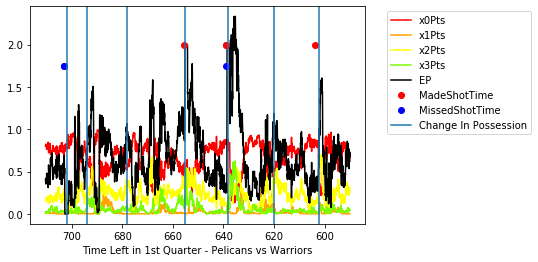

In [32]:
graphData = newtemp[0:3000].copy()
plt.figure()
plt.plot(graphData['game_clock'],graphData['x0Pts'],label='x0Pts',color='red')
plt.plot(graphData['game_clock'],graphData['x1Pts'],label='x1Pts',color='orange')
plt.plot(graphData['game_clock'],graphData['x2Pts'],label='x2Pts',color='yellow')
plt.plot(graphData['game_clock'],graphData['x3Pts'],label='x3Pts',color='lawngreen')
plt.plot(graphData['game_clock'],graphData['EP'],label='EP',color='black')
plt.plot(shotsSmall['SHOT_TIME'],[2 for i in range(len(shotsSmall))],marker='o',linestyle='none',color='red',label='MadeShotTime')
plt.plot(shotsSmallMissed['SHOT_TIME'],[1.75 for i in range(len(shotsSmallMissed))],marker='o',linestyle='none',color='blue',label='MissedShotTime')
plt.gca().invert_xaxis()
plt.xlabel('Time Left in 1st Quarter - Pelicans vs Warriors')
plt.axvline(x=702)
plt.axvline(x=694)
plt.axvline(x=678)
plt.axvline(x=655)
plt.axvline(x=638)
plt.axvline(x=620)
plt.axvline(x=602,label='Change In Possession')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [33]:
shots2 = shots.loc[shots['GAME_ID'] == 21500035]

In [34]:
shots2.head(1)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,EVENTTIME,QUARTER,SHOT_TIME
5023,Shot Chart Detail,21500035,7,202691,Klay Thompson,1610612744,Golden State Warriors,1,10,52,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,21,-179.2396,173.4772,1,1,20151031,NOP,GSW,652,1.0,638.86


In [35]:
playerDict = {}
teamDict = {}
for i in range(len(shots2)):
    row = shots2.iloc[i]
    playerDict[row['PLAYER_ID']] = row['PLAYER_NAME']
    teamDict[row['TEAM_ID']] = row['TEAM_NAME']

In [44]:
temp2 = newtemp.copy()
temp2['Name'] = temp2['PlayerWithBall'].map(playerDict)
temp2['TeamName'] = temp2['TeamWithBall'].map(teamDict)

In [45]:
temp2[['EPA','TeamName']].groupby(by=['TeamName']).sum().reset_index()

,TeamName,EPA
0,Golden State Warriors,-2.909231
1,New Orleans Pelicans,-0.560064


In [46]:
groupedtemp2 = temp2[['EPA','Name']].groupby(by=['Name']).sum().reset_index().sort_values(by=['EPA'],ascending=False)
groupedtemp2['EPA'] = groupedtemp2.apply(lambda row: round(row['EPA'],2),axis=1)
groupedtemp2

,Name,EPA
19,Stephen Curry,17.28
3,Anthony Davis,10.43
20,Toney Douglas,9.82
18,Shaun Livingston,8.78
17,Ryan Anderson,2.07
2,Andre Iguodala,1.19
0,Alexis Ajinca,1.17
12,Kendrick Perkins,0.04
5,Dante Cunningham,-0.09
15,Luke Babbitt,-1.04


In [26]:
len(temp2.loc[((temp2['LastPossEvent']) & (pd.notnull(temp2['SHOT_TIME'])))])

9997